Here we are using VQC(variational Quantum Classifier) along as a QML model for binary classification of image dataset. For the hyperparameter optimisation genetic programming using mutation is used.

Importing Pennylane

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Importing Cifar10 dataset

In [ ]:
# Load the CIFAR-10 dataset using Keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten the CIFAR-10 images (32x32x3) into a feature vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Select only the first two classes (e.g., 'airplane' and 'automobile')
class_indices = (y_train.squeeze() == 0) | (y_train.squeeze() == 1)
X_train = X_train[class_indices]
y_train = y_train[class_indices]

# Randomly select a subset of around 100 images
subset_size = 100
random_indices = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
X_train = X_train[random_indices]
y_train = y_train[random_indices]

# Apply PCA for dimensionality reduction to 4 features
pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)

# Normalize the data
X_train = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X_train)

# Split the data into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
n_qubits = X_train.shape[1]


170498071/170498071 [==============================] - 3s 0us/step


Model Defining

In [ ]:
# Define the quantum device
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit
@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Variational quantum classifier
def variational_classifier(theta, x=None):
    weights = theta[0]
    bias = theta[1]
    return circuit(weights, x=x) + bias

# Cost function
def cost(theta, X, expectations):
    e_predicted = np.array([variational_classifier(theta, x=x) for x in X])
    loss = np.mean((e_predicted - expectations) ** 2)
    return loss


Optimisation

In [ ]:
# Generate random initial weights for the quantum circuit
n_layers = 3
np.random.seed(42)
theta_weights = np.random.uniform(0, 2 * np.pi, size=(n_layers, n_qubits, 3))
theta_bias = 0.0
theta_init = (theta_weights, theta_bias)
# Define the mutation function for evolutionary optimization
def mutate(theta, mutation_rate):
    # Convert theta to a list for mutation
    theta_list = list(theta)
    mutated_theta = theta_list.copy()
    for i in range(len(theta_list[0])):
        if np.random.rand() < mutation_rate:
            mutated_theta[0][i] = np.random.uniform(0, 2 * np.pi)
    # Convert mutated_theta back to a tuple
    mutated_theta = (mutated_theta[0], mutated_theta[1])
    return mutated_theta


# Lists to store data for plotting
losses = []
best_losses = []
best_thetas = []

# Set the hyperparameters
population_size = 50
mutation_rate = 0.01
num_epochs = 20

# Optimize the weights
best_theta = theta_init  # Initialize best_theta
best_loss = cost(best_theta, X_train, y_train)  # Initialize best_loss

for epoch in range(num_epochs):
    print("Generation:", epoch)
    new_population = []

    for _ in range(population_size):
        mutated_theta = mutate(best_theta, mutation_rate)
        loss = cost(mutated_theta, X_train, y_train)

        if loss < best_loss:
            best_theta = mutated_theta
            best_loss = loss

        new_population.append((mutated_theta, loss))

    print("Best Loss in Generation {}: {}".format(epoch, best_loss))

    # Store data for plotting
    best_losses.append(best_loss)
    losses.append([loss for _, loss in new_population])
    best_thetas.append(best_theta)

# Final loss and final theta
final_loss = best_loss
final_theta = best_theta

# Print the final results
print("Final Loss:", final_loss)
print("Final Theta:", final_theta)



# Predict with optimized weights on validation data
e_predicted_validation = np.array([variational_classifier(final_theta, x=x) for x in X_validation])

# Convert expectations to classes
prob_class_one = (e_predicted_validation + 1.0) / 2.0
y_pred_validation = (prob_class_one >= 0.5)

# Calculate accuracy on the validation data
validation_accuracy = accuracy_score(y_validation, y_pred_validation)

print("Validation Accuracy:", validation_accuracy)


Generation: 0
Best Loss in Generation 0: 0.28332708129974976
Generation: 1
Best Loss in Generation 1: 0.28332708129974976
Generation: 2
Best Loss in Generation 2: 0.28332708129974976
Generation: 3
Best Loss in Generation 3: 0.28332708129974976
Generation: 4
Best Loss in Generation 4: 0.28332708129974976
Generation: 5
Best Loss in Generation 5: 0.28332708129974976
Generation: 6
Best Loss in Generation 6: 0.28332708129974976
Generation: 7
Best Loss in Generation 7: 0.28332708129974976
Generation: 8
Best Loss in Generation 8: 0.28332708129974976
Generation: 9
Best Loss in Generation 9: 0.28332708129974976
Generation: 10
Best Loss in Generation 10: 0.28332708129974976
Generation: 11
Best Loss in Generation 11: 0.28332708129974976
Generation: 12
Best Loss in Generation 12: 0.28332708129974976
Generation: 13
Best Loss in Generation 13: 0.28332708129974976
Generation: 14
Best Loss in Generation 14: 0.28332708129974976
Generation: 15
Best Loss in Generation 15: 0.28332708129974976
Generation: 

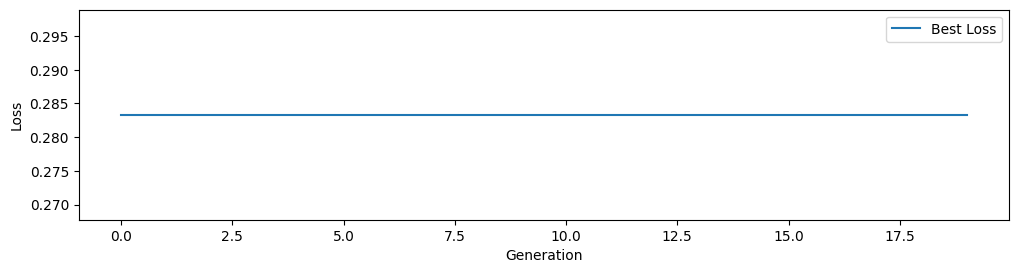

In [ ]:
# Visualize changes
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(best_losses, label="Best Loss")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.legend()


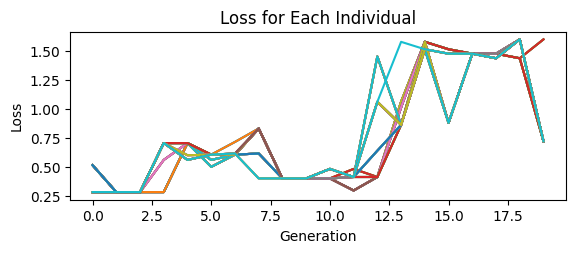

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(losses)
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Loss for Each Individual")
plt.show()
